# Finch vs Unzipping Benchmark

This notebook compares the performance of Finch and Unzipping implementations for the Hadamard product with transpose pattern: `A(i,j) = B(i,j) * C(j,i)`.

## Setup

In [1]:
include("kernels.jl")
include("utils.jl")

using PrettyTables

import BenchmarkTools
import Libdl
import Plots
import Printf: @sprintf
import SparseArrays

# C Library Wrapers
const LIB_HANDLE = Ref{Ptr{Cvoid}}(C_NULL)

function c_generate_csr_matrix(m::Int, n::Int, sparsity::Float64, seed::UInt32)
    func = Libdl.dlsym(LIB_HANDLE[], :generate_csr_matrix)
    return ccall(func, Ptr{Cvoid}, (Cint, Cint, Cdouble, Cuint), m, n, sparsity, seed)
end

function c_allocate_result_csr(m::Int, max_nnz::Int)
    func = Libdl.dlsym(LIB_HANDLE[], :allocate_result_csr)
    return ccall(func, Ptr{Cvoid}, (Cint, Cint), m, max_nnz)
end

function c_reset_csr_result(mat::Ptr{Cvoid})
    func = Libdl.dlsym(LIB_HANDLE[], :reset_csr_result)
    ccall(func, Cvoid, (Ptr{Cvoid},), mat)
end

function c_hadamard_transpose(B::Ptr{Cvoid}, C::Ptr{Cvoid}, A::Ptr{Cvoid})
    func = Libdl.dlsym(LIB_HANDLE[], :hadamard_transpose)
    ccall(func, Cvoid, (Ptr{Cvoid}, Ptr{Cvoid}, Ptr{Cvoid}), B, C, A)
end

function c_free_csr_matrix(mat::Ptr{Cvoid})
    func = Libdl.dlsym(LIB_HANDLE[], :free_csr_matrix)
    ccall(func, Cvoid, (Ptr{Cvoid},), mat)
end

# Load C library
lib_path = Utils.compile_library()
LIB_HANDLE[] = Libdl.dlopen(lib_path, Libdl.RTLD_LAZY | Libdl.RTLD_GLOBAL)
println("✓ Loaded library: $lib_path")

⚠ Compiling Unzipping library...
✓ Compiled successfully: /home/yz/unzip-bench/libkernels.so
✓ Loaded library: /home/yz/unzip-bench/libkernels.so


## Create Benchmark Suite

In [2]:
function create_finch_benchmark(m, n, sparsity_B, sparsity_C)
    B_sparse = Utils.generate_sparse_matrix(m, n, sparsity_B, seed=42)
    C_sparse = Utils.generate_sparse_matrix(n, m, sparsity_C, seed=43)
    
    t_start_B = time_ns()
    B_finch = Utils.to_finch_csr(B_sparse)
    t_end_B = time_ns()
    time_B_ms = (t_end_B - t_start_B) / 1e6
    
    t_start_C = time_ns()
    C_finch = Utils.to_finch_csr(C_sparse)
    t_end_C = time_ns()
    time_C_ms = (t_end_C - t_start_C) / 1e6
    
    println("to_finch_csr (m=$m, n=$n) - B: $(round(time_B_ms, digits=3)) ms, C: $(round(time_C_ms, digits=3)) ms")
    
    return BenchmarkTools.@benchmarkable FinchKernels.hadamard_transpose!($B_finch, $C_finch)
end

function create_unzip_benchmark(m, n, sparsity_B, sparsity_C, unzip_B=true)
    B_sparse = Utils.generate_sparse_matrix(m, n, sparsity_B, seed=42)
    C_sparse = Utils.generate_sparse_matrix(n, m, sparsity_C, seed=43)
    B_c = c_generate_csr_matrix(m, n, sparsity_B, UInt32(42))
    C_c = c_generate_csr_matrix(n, m, sparsity_C, UInt32(43))
    max_nnz = SparseArrays.nnz(B_sparse) + SparseArrays.nnz(C_sparse)
    A_c = c_allocate_result_csr(m, max_nnz)

    if unzip_B
        return BenchmarkTools.@benchmarkable c_hadamard_transpose($B_c, $C_c, $A_c) setup = (c_reset_csr_result($A_c))
    else
        return BenchmarkTools.@benchmarkable c_hadamard_transpose($C_c, $B_c, $A_c) setup = (c_reset_csr_result($A_c))
    end
end

suite = BenchmarkTools.BenchmarkGroup()

# Size variation (fixed sparsity = 0.05)
suite["matrix_size"] = BenchmarkTools.BenchmarkGroup()
sizes = [100, 200, 500, 1000, 2000, 3000, 5000]
fixed_sparsity = 0.05

for size in sizes
    suite["matrix_size"]["finch", size] = create_finch_benchmark(size, size, fixed_sparsity, fixed_sparsity)
    suite["matrix_size"]["unzip", size] = create_unzip_benchmark(size, size, fixed_sparsity, fixed_sparsity)
end

# Sparsity variation (fixed size = 1000)
suite["matrix_sparsity"] = BenchmarkTools.BenchmarkGroup()
fixed_size = 1000
sparsities = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30]

for sparsity in sparsities
    suite["matrix_sparsity"]["finch", sparsity] = create_finch_benchmark(fixed_size, fixed_size, sparsity, sparsity)
    suite["matrix_sparsity"]["unzip", sparsity] = create_unzip_benchmark(fixed_size, fixed_size, sparsity, sparsity)
end

# Unzip B vs C comparison
suite["unzip_comparison"] = BenchmarkTools.BenchmarkGroup()
test_size = 1000
base_sparsity = 0.05
ratios = [0.2, 0.5, 1.0, 2.0, 5.0]

sparsity_B = [min(base_sparsity * sqrt(r), 0.3) for r in ratios]
sparsity_C = [max(base_sparsity / sqrt(r), 0.01) for r in ratios]

for (i, ratio) in enumerate(ratios)
    suite["unzip_comparison"]["unzip_B", ratio] = create_unzip_benchmark(test_size, test_size, sparsity_B[i], sparsity_C[i], true)
    suite["unzip_comparison"]["unzip_C", ratio] = create_unzip_benchmark(test_size, test_size, sparsity_B[i], sparsity_C[i], false)
end
;

to_finch_csr (m=100, n=100) - B: 698.406 ms, C: 0.019 ms
to_finch_csr (m=200, n=200) - B: 0.081 ms, C: 0.043 ms
to_finch_csr (m=500, n=500) - B: 1.602 ms, C: 1.537 ms
to_finch_csr (m=1000, n=1000) - B: 5.746 ms, C: 21.028 ms
to_finch_csr (m=2000, n=2000) - B: 29.627 ms, C: 43.036 ms
to_finch_csr (m=3000, n=3000) - B: 60.956 ms, C: 54.418 ms
to_finch_csr (m=5000, n=5000) - B: 208.583 ms, C: 404.694 ms
to_finch_csr (m=1000, n=1000) - B: 5.69 ms, C: 5.56 ms
to_finch_csr (m=1000, n=1000) - B: 5.692 ms, C: 7.961 ms
to_finch_csr (m=1000, n=1000) - B: 1.263 ms, C: 1.173 ms
to_finch_csr (m=1000, n=1000) - B: 1.061 ms, C: 1.046 ms
to_finch_csr (m=1000, n=1000) - B: 1.189 ms, C: 1.09 ms
to_finch_csr (m=1000, n=1000) - B: 4.966 ms, C: 163.267 ms
to_finch_csr (m=1000, n=1000) - B: 1.256 ms, C: 3.684 ms


# Run Benchmark Suite

In [3]:
results = run(suite, verbose=true)
min_results = BenchmarkTools.minimum(results)
med_results = BenchmarkTools.median(results)

(1/3) benchmarking "matrix_size"...
  (1/14) benchmarking ("unzip", 500)...
  done (took 2.244432083 seconds)
  (2/14) benchmarking ("finch", 3000)...
  done (took 14.730500388 seconds)
  (3/14) benchmarking ("unzip", 3000)...
  done (took 5.646241837 seconds)
  (4/14) benchmarking ("unzip", 100)...
  done (took 0.635520399 seconds)
  (5/14) benchmarking ("finch", 1000)...
  done (took 5.773301496 seconds)
  (6/14) benchmarking ("finch", 200)...
  done (took 5.608619312 seconds)
  (7/14) benchmarking ("finch", 2000)...
  done (took 6.306872841 seconds)
  (8/14) benchmarking ("unzip", 200)...
  done (took 0.701766836 seconds)
  (9/14) benchmarking ("finch", 500)...
  done (took 5.614411597 seconds)
  (10/14) benchmarking ("unzip", 1000)...
  done (took 5.59974192 seconds)
  (11/14) benchmarking ("unzip", 2000)...
  done (took 5.611694015 seconds)
  (12/14) benchmarking ("finch", 5000)...
  done (took 13.677667529 seconds)
  (13/14) benchmarking ("finch", 100)...
  done (took 4.169819652

3-element BenchmarkTools.BenchmarkGroup:
  tags: []
  "matrix_size" => 14-element BenchmarkTools.BenchmarkGroup:
	  tags: []
	  ("unzip", 500) => TrialEstimate(159.031 μs)
	  ("finch", 3000) => TrialEstimate(1.290 s)
	  ("unzip", 3000) => TrialEstimate(14.713 ms)
	  ("unzip", 100) => TrialEstimate(1.077 μs)
	  ("finch", 1000) => TrialEstimate(73.846 ms)
	  ("finch", 200) => TrialEstimate(1.373 ms)
	  ("finch", 2000) => TrialEstimate(449.194 ms)
	  ("unzip", 200) => TrialEstimate(9.752 μs)
	  ("finch", 500) => TrialEstimate(12.554 ms)
	  ("unzip", 1000) => TrialEstimate(800.940 μs)
	  ⋮
  "matrix_sparsity" => 14-element BenchmarkTools.BenchmarkGroup:
	  tags: []
	  ("unzip", 0.3) => TrialEstimate(15.778 ms)
	  ("finch", 0.1) => TrialEstimate(73.618 ms)
	  ("finch", 0.15) => TrialEstimate(71.114 ms)
	  ("finch", 0.3) => TrialEstimate(71.563 ms)
	  ("unzip", 0.1) => TrialEstimate(2.397 ms)
	  ("unzip", 0.15) => TrialEstimate(4.702 ms)
	  ("finch", 0.05) => TrialEstimate(73.515 ms)
	  ("un

## Time vs Matrix Size

Visualize how performance scales with matrix size (fixed sparsity = 5%).

In [4]:
sz_finch_min_time = [min_results["matrix_size"]["finch", s].time for s in sizes]
sz_unzip_min_time = [min_results["matrix_size"]["unzip", s].time for s in sizes]
sz_finch_med_time = [med_results["matrix_size"]["finch", s].time for s in sizes]
sz_unzip_med_time = [med_results["matrix_size"]["unzip", s].time for s in sizes]
sz_finch_med_memory = [med_results["matrix_size"]["finch", s].memory for s in sizes]
sz_unzip_med_memory = [med_results["matrix_size"]["unzip", s].memory for s in sizes]
speedups = sz_finch_min_time ./ sz_unzip_min_time
;

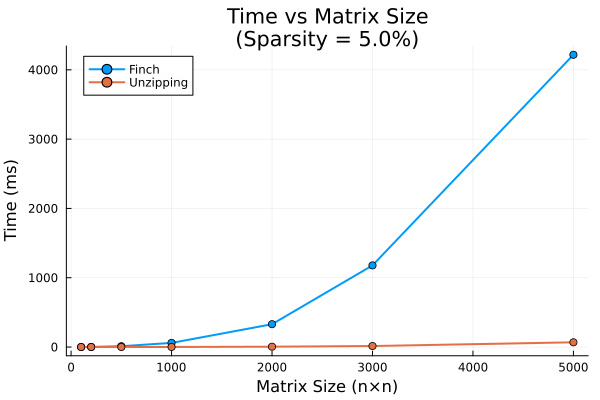

In [5]:
# Time plot
plot_size_time = Plots.plot(
    sizes, [sz_finch_min_time./1e6 sz_unzip_min_time./1e6],
    label=["Finch" "Unzipping"],
    xlabel="Matrix Size (n×n)",
    ylabel="Time (ms)",
    title="Time vs Matrix Size\n(Sparsity = $(fixed_sparsity*100)%)",
    linewidth=2,
    marker=:circle
)

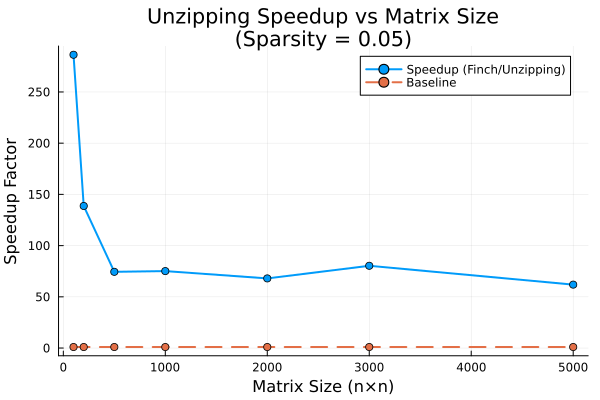

In [6]:
# Speedup plot
plot_size_speedup = Plots.plot(
    sizes, [speedups ones(length(sizes))],
    label=["Speedup (Finch/Unzipping)" "Baseline"],
    xlabel="Matrix Size (n×n)",
    ylabel="Speedup Factor",
    title="Unzipping Speedup vs Matrix Size\n(Sparsity = $fixed_sparsity)",
    linestyle=[:solid :dash],
    linewidth=2,
    marker=:circle
)

In [7]:
# Details table
table_data = Matrix{Any}(undef, length(sizes), 8)
for (i, s) in enumerate(sizes)
    table_data[i, 1] = s
    table_data[i, 2] = BenchmarkTools.prettytime(sz_finch_min_time[i])
    table_data[i, 3] = BenchmarkTools.prettytime(sz_finch_med_time[i])
    table_data[i, 4] = BenchmarkTools.prettymemory(sz_finch_med_memory[i])
    table_data[i, 5] = BenchmarkTools.prettytime(sz_unzip_min_time[i])
    table_data[i, 6] = BenchmarkTools.prettytime(sz_unzip_med_time[i])
    table_data[i, 7] = BenchmarkTools.prettymemory(sz_unzip_med_memory[i])
    table_data[i, 8] = @sprintf("%.2f×", speedups[i])
end

println("\nTime vs Matrix Size (Sparsity = $fixed_sparsity)")
pretty_table(
    table_data;
    column_labels=[
        ["Size", "Finch", "", "", "Unzip", "", "", "Speedup"],
        ["", "Time", "", "Memory", "Time", "", "Memory", ""],
        ["", "Min", "Med", "", "Min", "Med", "", ""]
    ],
    merge_column_label_cells=[
        MergeCells(1, 2, 3, "Finch"),
        MergeCells(1, 5, 3, "Unzip"),
        MergeCells(2, 2, 2, "Time"),
        MergeCells(2, 5, 2, "Time")
    ],
    alignment=:r,
    column_label_alignment=:c,
    display_size=(-1, -1)
)


Time vs Matrix Size (Sparsity = 0.05)
┌──────┬──────────────────────────────────────┬───────────────────────────────────┬─────────┐
│ Size │                Finch                 │               Unzip               │ Speedup │
│      │          Time           │   Memory   │          Time           │ Memory  │         │
│      │    Min     │    Med     │            │    Min     │    Med     │         │         │
├──────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────┼─────────┤
│  100 │ 295.194 μs │ 310.545 μs │   1.63 MiB │   1.031 μs │   1.077 μs │ 0 bytes │ 286.32× │
│  200 │   1.331 ms │   1.373 ms │   7.59 MiB │   9.599 μs │   9.752 μs │ 0 bytes │ 138.70× │
│  500 │  11.692 ms │  12.554 ms │  40.29 MiB │ 157.116 μs │ 159.031 μs │ 0 bytes │  74.42× │
│ 1000 │  59.653 ms │  73.846 ms │ 176.48 MiB │ 793.985 μs │ 800.940 μs │ 0 bytes │  75.13× │
│ 2000 │ 329.490 ms │ 449.194 ms │ 722.80 MiB │   4.847 ms │   4.873 ms │ 0 bytes │  67.98× │
│ 3000 │    1.178 s │

## Time vs Sparsity

Visualize how performance scales with sparsity (fixed size = 1000×1000).

In [8]:
sp_finch_min_time = [min_results["matrix_sparsity"]["finch", sp].time for sp in sparsities]
sp_unzip_min_time = [min_results["matrix_sparsity"]["unzip", sp].time for sp in sparsities]
sp_finch_med_time = [med_results["matrix_sparsity"]["finch", sp].time for sp in sparsities]
sp_unzip_med_time = [med_results["matrix_sparsity"]["unzip", sp].time for sp in sparsities]
sp_finch_med_memory = [med_results["matrix_sparsity"]["finch", sp].memory for sp in sparsities]
sp_unzip_med_memory = [med_results["matrix_sparsity"]["unzip", sp].memory for sp in sparsities]
;

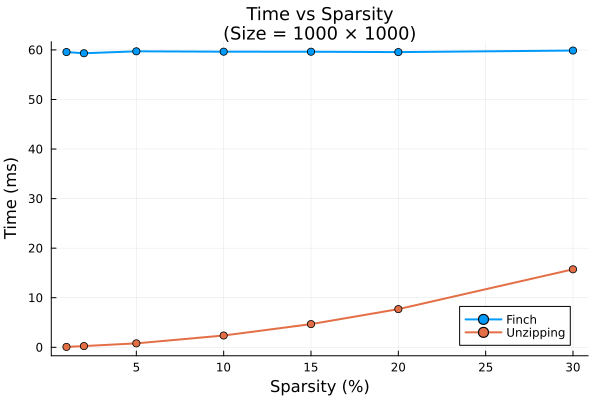

In [9]:
# Time plot
plot_sparsity_time = Plots.plot(
    sparsities .* 100, [sp_finch_min_time./1e6 sp_unzip_min_time./1e6],
    label=["Finch" "Unzipping"],
    xlabel="Sparsity (%)",
    ylabel="Time (ms)",
    title="Time vs Sparsity\n(Size = $fixed_size × $fixed_size)",
    titlefontsize=12,
    linewidth=2,
    marker=:circle
)

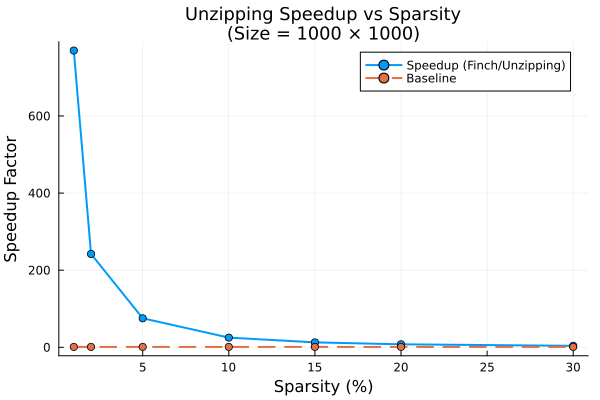

In [10]:
# Speedup plot
speedups_sp = sp_finch_min_time ./ sp_unzip_min_time

plot_sparsity_speedup = Plots.plot(
    sparsities .* 100, [speedups_sp ones(length(sparsities))],
    label=["Speedup (Finch/Unzipping)" "Baseline"],
    xlabel="Sparsity (%)",
    ylabel="Speedup Factor",
    title="Unzipping Speedup vs Sparsity\n(Size = $fixed_size × $fixed_size)",
    titlefontsize=12,
    linestyle=[:solid :dash],
    linewidth=2,
    marker=:circle
)

In [11]:
# Details table
table_data = Matrix{Any}(undef, length(sparsities), 8)
for (i, sp) in enumerate(sparsities)
    table_data[i, 1] = @sprintf("%.1f", sp * 100)
    table_data[i, 2] = BenchmarkTools.prettytime(sp_finch_min_time[i])
    table_data[i, 3] = BenchmarkTools.prettytime(sp_finch_med_time[i])
    table_data[i, 4] = BenchmarkTools.prettymemory(sp_finch_med_memory[i])
    table_data[i, 5] = BenchmarkTools.prettytime(sp_unzip_min_time[i])
    table_data[i, 6] = BenchmarkTools.prettytime(sp_unzip_med_time[i])
    table_data[i, 7] = BenchmarkTools.prettymemory(sp_unzip_med_memory[i])
    table_data[i, 8] = @sprintf("%.2f×", sp_finch_min_time[i] / sp_unzip_min_time[i])
end

println("\nTime vs Sparsity (Size = $fixed_size × $fixed_size)")
pretty_table(
    table_data;
    column_labels=[
        ["Sparsity", "Finch", "", "", "Unzip", "", "", "Speedup"],
        ["(%)", "Time", "", "Memory", "Time", "", "Memory", ""],
        ["", "Min", "Med", "", "Min", "Med", "", ""]
    ],
    merge_column_label_cells=[
        MergeCells(1, 2, 3, "Finch"),
        MergeCells(1, 5, 3, "Unzip"),
        MergeCells(2, 2, 2, "Time"),
        MergeCells(2, 5, 2, "Time")
    ],
    alignment=:r,
    column_label_alignment=:c,
    minimum_data_column_widths=[8, 0, 0, 0, 0, 0, 0, 0],
    display_size=(-1, -1)
)


Time vs Sparsity (Size = 1000 × 1000)
┌──────────┬────────────────────────────────────┬───────────────────────────────────┬─────────┐
│ Sparsity │               Finch                │               Unzip               │ Speedup │
│   (%)    │         Time          │   Memory   │          Time           │ Memory  │         │
│          │    Min    │    Med    │            │    Min     │    Med     │         │         │
├──────────┼───────────┼───────────┼────────────┼────────────┼────────────┼─────────┼─────────┤
│      1.0 │ 59.569 ms │ 72.147 ms │ 176.48 MiB │  77.394 μs │  78.853 μs │ 0 bytes │ 769.69× │
│      2.0 │ 59.329 ms │ 72.489 ms │ 176.48 MiB │ 244.990 μs │ 247.970 μs │ 0 bytes │ 242.17× │
│      5.0 │ 59.719 ms │ 73.515 ms │ 176.48 MiB │ 793.792 μs │ 800.220 μs │ 0 bytes │  75.23× │
│     10.0 │ 59.646 ms │ 73.618 ms │ 176.48 MiB │   2.379 ms │   2.397 ms │ 0 bytes │  25.07× │
│     15.0 │ 59.637 ms │ 71.114 ms │ 176.48 MiB │   4.678 ms │   4.702 ms │ 0 bytes │  12.75× │
│

## Unzipping B vs C Comparison

Compare performance when unzipping different matrices (B vs C) with varying sparsity ratios.

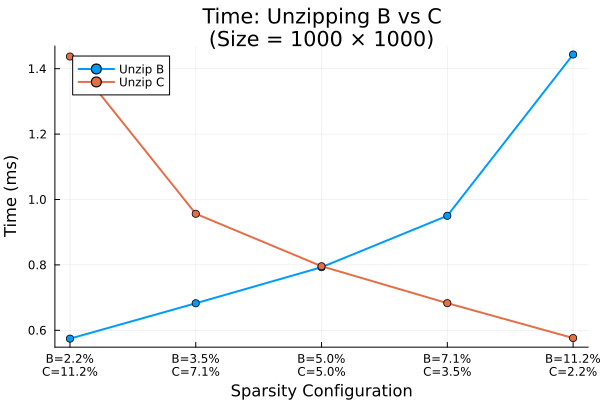

In [12]:
unzip_B_min_time = [min_results["unzip_comparison"]["unzip_B", r].time for r in ratios]
unzip_C_min_time = [min_results["unzip_comparison"]["unzip_C", r].time for r in ratios]
unzip_B_med_time = [med_results["unzip_comparison"]["unzip_B", r].time for r in ratios]
unzip_C_med_time = [med_results["unzip_comparison"]["unzip_C", r].time for r in ratios]
unzip_B_med_memory = [med_results["unzip_comparison"]["unzip_B", r].memory for r in ratios]
unzip_C_med_memory = [med_results["unzip_comparison"]["unzip_C", r].memory for r in ratios]

x_labels = ["B=$(round(sb * 100, digits=1))%\nC=$(round(sc * 100, digits=1))%"
            for (sb, sc) in zip(sparsity_B, sparsity_C)]

# Time comparison plot
plot_unzip_comparison = Plots.plot(
    1:length(ratios), [unzip_B_min_time./1e6 unzip_C_min_time./1e6],
    label=["Unzip B" "Unzip C"],
    xlabel="Sparsity Configuration",
    ylabel="Time (ms)",
    title="Time: Unzipping B vs C\n(Size = $test_size × $test_size)",
    xticks=(1:length(ratios), x_labels),
    linewidth=2,
    marker=:circle
)

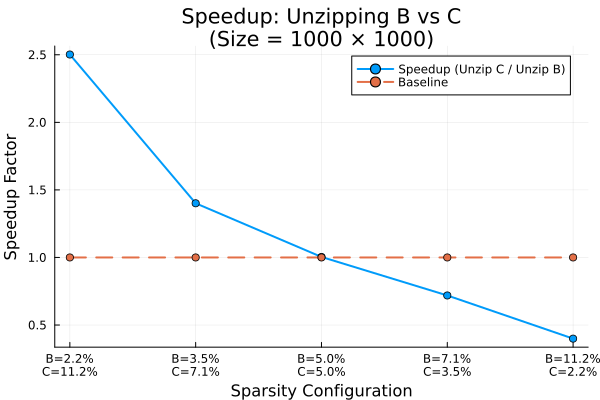

In [13]:
# Speedup comparison plot
speedup_B_vs_C = unzip_C_min_time ./ unzip_B_min_time

plot_unzip_speedup = Plots.plot(
    1:length(ratios), [speedup_B_vs_C ones(length(ratios))],
    label=["Speedup (Unzip C / Unzip B)" "Baseline"],
    xlabel="Sparsity Configuration",
    ylabel="Speedup Factor",
    title="Speedup: Unzipping B vs C\n(Size = $test_size × $test_size)",
    xticks=(1:length(ratios), x_labels),
    linestyle=[:solid :dash],
    linewidth=2,
    marker=:circle
)

In [14]:
table_data = Matrix{Any}(undef, length(ratios), 8)
for (i, (r, sb, sc)) in enumerate(zip(ratios, sparsity_B, sparsity_C))
    table_data[i, 1] = @sprintf("%.1f", sb * 100)
    table_data[i, 2] = @sprintf("%.1f", sc * 100)
    table_data[i, 3] = BenchmarkTools.prettytime(unzip_B_min_time[i])
    table_data[i, 4] = BenchmarkTools.prettytime(unzip_B_med_time[i])
    table_data[i, 5] = BenchmarkTools.prettytime(unzip_C_min_time[i])
    table_data[i, 6] = BenchmarkTools.prettytime(unzip_C_med_time[i])
    table_data[i, 7] = BenchmarkTools.prettymemory(unzip_C_med_memory[i])
    table_data[i, 8] = @sprintf("%.2f×", unzip_C_min_time[i] / unzip_B_min_time[i])
end

println("\nUnzipping B vs C (Size = $test_size × $test_size)")
pretty_table(
    table_data;
    column_labels=[
        ["Sparsity", "", "Unzip B", "", "Unzip C", "", "", "Speedup"],
        ["B (%)", "C (%)", "Time", "", "Time", "", "Memory", "(C/B)"],
        ["", "", "Min", "Med", "Min", "Med", "", ""]
    ],
    merge_column_label_cells=[
        MergeCells(1, 1, 2, "Sparsity"),
        MergeCells(1, 3, 2, "Unzip B"),
        MergeCells(1, 5, 3, "Unzip C"),
        MergeCells(2, 3, 2, "Time"),
        MergeCells(2, 5, 2, "Time")
    ],
    alignment=:r,
    column_label_alignment=:c,
    minimum_data_column_widths=[7, 7, 0, 0, 0, 0, 0, 0],
    display_size=(-1, -1)
)
println("\nNote: Speedup > 1.0 means unzipping B is faster; Speedup < 1.0 means unzipping C is faster")


Unzipping B vs C (Size = 1000 × 1000)
┌───────────────────┬─────────────────────────┬───────────────────────────────────┬─────────┐
│     Sparsity      │         Unzip B         │              Unzip C              │ Speedup │
│  B (%)  │  C (%)  │          Time           │          Time           │ Memory  │  (C/B)  │
│         │         │    Min     │    Med     │    Min     │    Med     │         │         │
├─────────┼─────────┼────────────┼────────────┼────────────┼────────────┼─────────┼─────────┤
│     2.2 │    11.2 │ 574.447 μs │ 579.340 μs │   1.437 ms │   1.448 ms │ 0 bytes │   2.50× │
│     3.5 │     7.1 │ 682.613 μs │ 688.140 μs │ 956.273 μs │ 962.971 μs │ 0 bytes │   1.40× │
│     5.0 │     5.0 │ 792.903 μs │ 799.917 μs │ 795.835 μs │ 801.240 μs │ 0 bytes │   1.00× │
│     7.1 │     3.5 │ 950.173 μs │ 955.407 μs │ 682.909 μs │ 688.364 μs │ 0 bytes │   0.72× │
│    11.2 │     2.2 │   1.443 ms │   1.452 ms │ 576.288 μs │ 581.330 μs │ 0 bytes │   0.40× │
└─────────┴─────────┴

## Cleanup

In [15]:
if LIB_HANDLE[] != C_NULL
    Libdl.dlclose(LIB_HANDLE[])
    println("✓ Library closed")
end

✓ Library closed
